In [1]:
import sys
sys.path.insert(0, "..")

import jax
import jax.numpy as jnp

from tqdm import tqdm
from functools import partial

import module.samplers
import module.hamiltonians
import module.wavefunctions

import optax
import numpy as np
from matplotlib import pyplot as plt

In [2]:
key = jax.random.PRNGKey(0)

## Hydrogen Atom

In this notebook we demonstrate a VMC method for finding the ground state of the hydrogen atom:

$$
H = -\frac{\hbar^2 }{2 m}\Delta - \frac{e^2}{4\pi\epsilon_0 r}
$$

The corresponding energies are known:
$$
E = -\frac{1}{n^2}\frac{m e^4}{32\pi^2\epsilon_{0}^2\hbar^2}
$$

We set $\hbar = m = 1$ and $e^4 = 32 \pi^2 \epsilon_{0}^2$. The ground state energy is thus:

$$
E = -1
$$

In the code, the hamiltonian is defined as follows:

In [3]:
#
# The potential energy function depending on the coordinates
#
def potential(x):
    return -jnp.sqrt(2)/jnp.sqrt(jnp.sum(x**2, axis = -1))


# the hamiltonian
H = module.hamiltonians.Particles(masses = [1], potential = potential, d_space = 3)

We use a very simple variational Ansatz:
$$
\Psi = \exp{-r\lambda}
$$
using $\lambda = e^a$, $a$ being the variational parameter. The ground state is found for $\lambda = \sqrt{2}$.

In [4]:
class Orbital(module.wavefunctions.Wavefunction):
    def __init__(self):
        super().__init__((3,))

    def init_parameters(self, key):
        return {"a": jax.random.normal(key)-3}

    def calc_logpsi(self, parameters, x):
        logpsi = -jnp.sqrt(jnp.sum(x**2, axis = -1)) * jnp.exp(parameters["a"])
        return logpsi

In [5]:
wavefun = Orbital()
parameters = wavefun.init_parameters(key)

We also initialise a MCMC sampler for our wavefunction and can take samples of it:

In [6]:
sampler = module.samplers.MCMC(wavefun, variance = 0.4)

Using the Hamiltonian, we can already compute the expected energy for our non-optimised wavefunction:

In [7]:
N = 10000
samples, ratio = sampler.sample(key, parameters, jax.random.normal(key, (3,)), N)
H_loc = H.calc_H_loc(wavefun, parameters, samples)

print("Acceptance Ratio:", ratio)
print("Expected Energy:", jnp.mean(H_loc))
print("Std of Expected Energy:", jnp.std(H_loc)/jnp.sqrt(N))

Acceptance Ratio: 0.979
Expected Energy: -0.05314303
Std of Expected Energy: 0.0006239213


To estimate the gradient of the expected energy via the formula:

$$
\nabla \left< E \right>  = 2\,\Re\, \mathbb{E}\{\nabla \log \Psi [H_{\mathrm{loc}}(r) - \mathbb{E}(E)]\}
$$

we implement a help function:

In [8]:
@partial(jax.jit, static_argnames=['hamiltonian', 'orbital'])
def calc_grad_E(hamiltonian, orbital, parameters, samples):
    """
    Calculates the gradient of the energy and the energy itself on a batch of samples.
    """

    E_loc = hamiltonian.calc_H_loc(orbital, parameters, samples)
    E = jnp.mean(E_loc)
    dE = jnp.std(E_loc)
    grad_log = orbital.grad_logpsi(parameters, samples)

    return jax.tree_util.tree_map(lambda tree: 2*jnp.real(jnp.mean(jnp.swapaxes(jnp.swapaxes(tree, 0, -1) * (E_loc - E), 0, -1), axis = 0)), grad_log), E, dE

The energy can now be optimised:

In [9]:
Es = []
dEs = []
ratios = []

# define
optimizer = optax.adam(learning_rate=0.01)

# initialise
optimizer_state = optimizer.init(parameters)

for i in tqdm(range(1000)):
    key, _ = jax.random.split(key)
    samples, ratio = sampler.sample(key, parameters, jax.random.normal(key, (3,)), 500)
    grad, E, dE = calc_grad_E(H, wavefun, parameters, samples)

    Es.append(E)
    dEs.append(dE)
    ratios.append(ratio)
    
    updates, optimizer_state = optimizer.update(grad, optimizer_state, parameters)
    parameters = optax.apply_updates(parameters, updates)

Es = np.array(Es)
dEs = np.array(dEs) / np.sqrt(500)
ratios = np.array(ratios)

  0%|          | 0/1000 [00:00<?, ?it/s]100%|██████████| 1000/1000 [00:02<00:00, 350.01it/s]


Text(0.5, 1.0, 'Energy Optimisation')

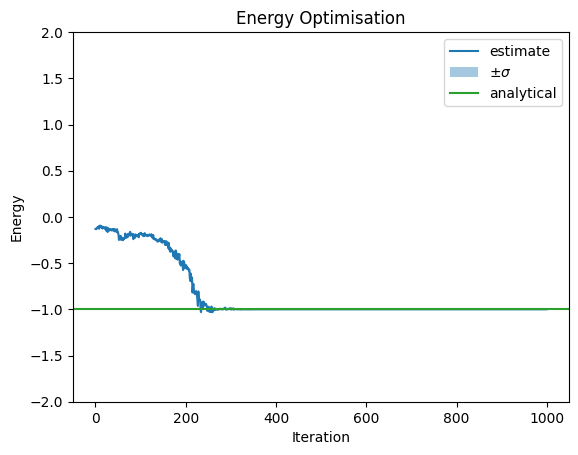

In [10]:
index = np.arange(Es.shape[0])

plt.plot(index, Es, label = "estimate")
plt.fill_between(index, Es - dEs, Es + dEs, alpha = 0.4, label = "$\\pm \\sigma$")
plt.ylim(-2,2)
plt.axhline(-1, color = "C2", label = "analytical")

plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.title("Energy Optimisation")

Text(0.5, 1.0, 'Energy Optimisation')

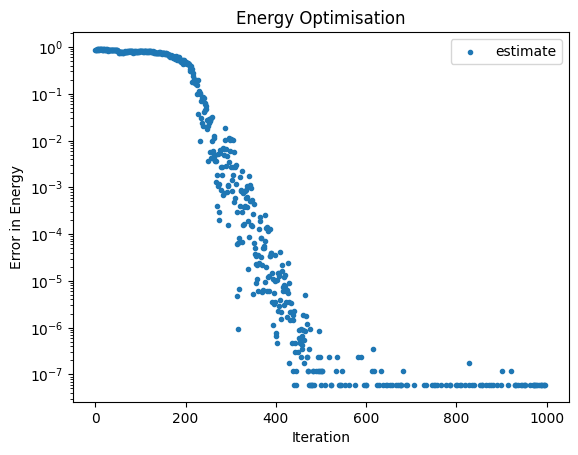

In [11]:
index = np.arange(Es.shape[0])

# plt.errorbar(index, np.abs(Es + 1), yerr = dEs, label = "estimate", fmt = ".")
plt.scatter(index, np.abs(Es + 1), label = "estimate", marker = ".")
# plt.fill_between(index, Es - dEs, Es + dEs, alpha = 0.4, label = "$\\pm \\sigma$")
# plt.ylim(-2,2)
# plt.axhline(-1, color = "C2", label = "analytical")
plt.yscale("log")

plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Error in Energy")
plt.title("Energy Optimisation")

In [12]:
jnp.exp(parameters["a"])**2

# should be 2

Array(1.9999999, dtype=float32)

Now, the variance of the expected energy has decreased, as expected for correct eigenstate:

In [13]:
N = 10000
samples, ratio = sampler.sample(key, parameters, jax.random.normal(key, (3,)), N)
H_loc = H.calc_H_loc(wavefun, parameters, samples)

print("Acceptance Ratio:", ratio)
print("Expected Energy:", jnp.mean(H_loc))
print("Std of Expected Energy:", jnp.std(H_loc)/jnp.sqrt(N))

Acceptance Ratio: 0.44009998
Expected Energy: -1.0
Std of Expected Energy: 2.3154392e-09


---